# Modeling Text Generation in Humans and LLMs

Metrics:

- Cosine distance between each subsequent token.
    - Different layers?
- Number of clusters.
- Intrinsic dimensionality.
- Probability of cluster change.
- Surprisal between subsequent tokens.

In [131]:
import pandas as pd

import functools
import torch
import torch.nn.functional as F

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.manifold import Isomap

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


### Model imports
from transformers import AutoModelForCausalLM, AutoTokenizer, BertModel, BertConfig, BertForMaskedLM, BertTokenizer
from transformers import GPT2Tokenizer, GPT2ForTokenClassification, AutoModelForCausalLM
import transformers

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

In [2]:
df = pd.read_csv("../data/corpora/readability/clear_modified/gpt-4-1106-preview_modified_with_all_metrics.csv")
df.head(3)

,Excerpt,GPT_rating_original,GPT_Response,GPT_rating_modified,Original,Goal,Og_Flesch,Modified_Flesch,Og_SMOG,Modified_SMOG,...,Modified_ARI,Og_Length,Modified_Length,SMOG_diff,ARI_diff,Flesch_diff,GPT_diff,Length_diff,Og_GPT,Modified_GPT
0,"Then the man took off his hat and walked away,...",85.0,The man tipped his hat and left. Philip and hi...,85.0,"Then the man took off his hat and walked away,...",Easier,79.13,84.78,7.8,6.3,...,6.0,184,149,1.5,4.8,-5.65,0.0,35,85.0,85.0
1,"Then the man took off his hat and walked away,...",85.0,"Subsequently, the gentleman doffed his headgea...",25.0,"Then the man took off his hat and walked away,...",Harder,79.13,26.74,7.8,18.0,...,18.9,184,189,-10.2,-8.1,52.39,60.0,-5,85.0,25.0
2,"There were but few passengers on deck, for it ...",85.0,Not many people were out on the deck because i...,85.0,"There were but few passengers on deck, for it ...",Easier,74.15,70.13,8.3,9.8,...,8.2,218,170,-1.5,4.3,4.02,0.0,48,85.0,85.0


### Helper functions

In [3]:
### ... find the target tokens within tokenized sequence
def find_sublist_index(mylist, sublist):
    """Find the first occurence of sublist in list.
    Return the start and end indices of sublist in list"""

    for i in range(len(mylist)):
        if mylist[i] == sublist[0] and mylist[i:i+len(sublist)] == sublist:
            return i, i+len(sublist)
    return None

@functools.lru_cache(maxsize=None)  # This will cache results, handy later...


### ... grab the embeddings for your target tokens
def get_embedding(model, tokenizer, sentence, target, layer, device):
    """Get a token embedding for target in sentence"""
    
    # Tokenize sentence
    inputs = tokenizer(sentence, return_tensors="pt").to(device)
    
    # Tokenize target
    target_enc = tokenizer.encode(target, return_tensors="pt",
                                  add_special_tokens=False).to(device)
    
    # Get indices of target in input tokens
    target_inds = find_sublist_index(
        inputs["input_ids"][0].tolist(),
        target_enc[0].tolist()
    )

    # Run model
    with torch.no_grad():
        output = model(**inputs)
        hidden_states = output.hidden_states

    # Get layer
    selected_layer = hidden_states[layer][0]

    #grab just the embeddings for your target word's token(s)
    token_embeddings = selected_layer[target_inds[0]:target_inds[1]]

    #if a word is represented by >1 tokens, take mean
    #across the multiple tokens' embeddings
    embedding = torch.mean(token_embeddings, dim=0)
    
    return embedding

### Setup models

In [4]:
### TODO: set up device?

In [5]:
### TODO: Update models
MODELS = [
          'EleutherAI/pythia-14m',
          'EleutherAI/pythia-70m',
          'EleutherAI/pythia-160m',
          'EleutherAI/pythia-410m',
          'EleutherAI/pythia-1b',
          'EleutherAI/pythia-1.4b',
          'EleutherAI/pythia-2.8b'
]

In [186]:
mpath = MODELS[3]
mpath

'EleutherAI/pythia-410m'

In [187]:
model = transformers.AutoModelForCausalLM.from_pretrained(mpath, output_hidden_states=True)
tokenizer = transformers.AutoTokenizer.from_pretrained(mpath)  

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Passages

In [170]:
def embed_passage(passage, model, tokenizer):
    """Embeds passage using a model and tokenizer."""

    ### Code to get hidden states
    inputs = tokenizer(passage,  return_tensors="pt")
    # Run model
    with torch.no_grad():
        output = model(**inputs)
        hidden_states = output.hidden_states

    ## Return
    return hidden_states

def get_distances(hidden_states, layer):
    """Takes a matrix of embeddings across layers and gets subsequent distances for a given layer."""

    ### Get layer
    target_layer = hidden_states[layer][0]
    
    # Iterate through the sequence and calculate cosine distances
    cosine_distances = []
    for i in range(1, target_layer.shape[0]):
        embedding_1 = target_layer[i-1]
        embedding_2 = target_layer[i]
        
        # Calculate cosine similarity (we subtract it from 1 to get cosine distance)
        cosine_similarity = F.cosine_similarity(embedding_1, embedding_2, dim=0)
        cosine_distance = 1 - cosine_similarity
        
        cosine_distances.append(cosine_distance.item())

    return np.array(cosine_distances)

def calculate_id_pca(hidden_states, layer, variance_threshold = .95):

    ### Get layer
    data = hidden_states[layer][0]

    ### Fit PCA
    pca_id = PCA()
    pca_id.fit(data)
    # Calculate the cumulative explained variance
    cumulative_variance = np.cumsum(pca_id.explained_variance_ratio_)
    # Determine the number of components needed to reach the variance threshold
    intrinsic_dim = np.argmax(cumulative_variance >= .95) + 1

    return intrinsic_dim


def calculate_optimal_clusters(hidden_states, layer, max_clusters=10):

    ### Get layer
    data = hidden_states[layer][0]
    
    # Lists to store inertia (for the Elbow Method) and silhouette scores
    inertia_list = []
    silhouette_scores = []
    
    # Fit KMeans for different numbers of clusters
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        
        # Append the inertia (sum of squared distances to the nearest cluster center)
        inertia_list.append(kmeans.inertia_)
        
        # Calculate the silhouette score and append it
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    optimal_silhouette = np.argmax(silhouette_scores) + 2  # Adding 2 to align with 2-indexing in range
    return optimal_silhouette

In [171]:
original = df.iloc[5]['Original']
modified = df.iloc[5]['GPT_Response']

original_embedded = embed_passage(original, model, tokenizer)
modified_embedded = embed_passage(modified, model, tokenizer)

original_distances = get_distances(original_embedded, 12)
modified_distances = get_distances(modified_embedded, 12)

IndexError: tuple index out of range

In [172]:
calculate_optimal_clusters(original_embedded, 12)

IndexError: tuple index out of range

In [173]:
calculate_optimal_clusters(modified_embedded, 12)

IndexError: tuple index out of range

In [174]:
### Fit PCA
pca = PCA()
pca.fit(hs)
# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
# Determine the number of components needed to reach the variance threshold
intrinsic_dim = np.argmax(cumulative_variance >= .95) + 1

In [175]:
calculate_id_pca(original_embedded, 12)

IndexError: tuple index out of range

In [35]:
original_embedded[12][0].shape

torch.Size([240, 768])

In [17]:
original_distances.mean()

0.01389666980280537

In [18]:
modified_distances.mean()

0.019193313535182707

<Axes: >

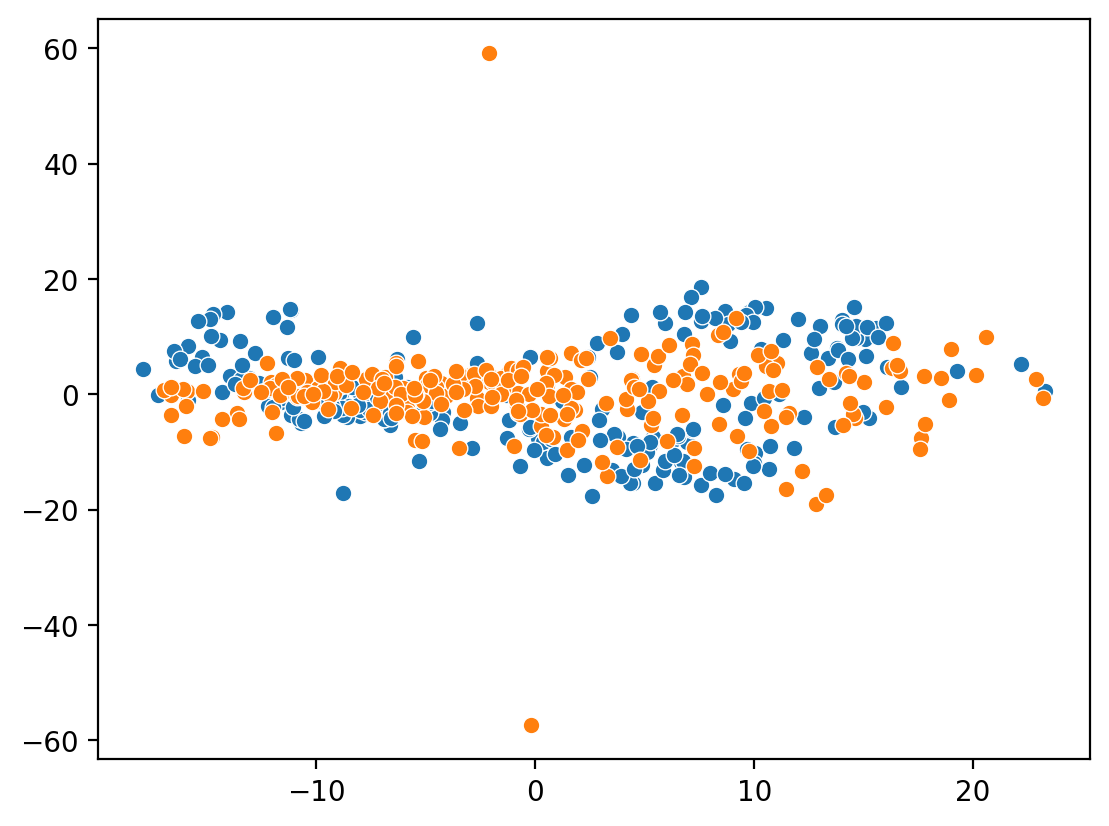

In [239]:
### PCA
pca = PCA(n_components=3)

original_reduced = pca.fit_transform(original_embedded[10][0])
modified_reduced = pca.fit_transform(modified_embedded[10][0])

sns.scatterplot(x = modified_reduced[:, 1], y = modified_reduced[:, 2])
sns.scatterplot(x = original_reduced[:, 1], y = original_reduced[:, 2])

<Axes: >

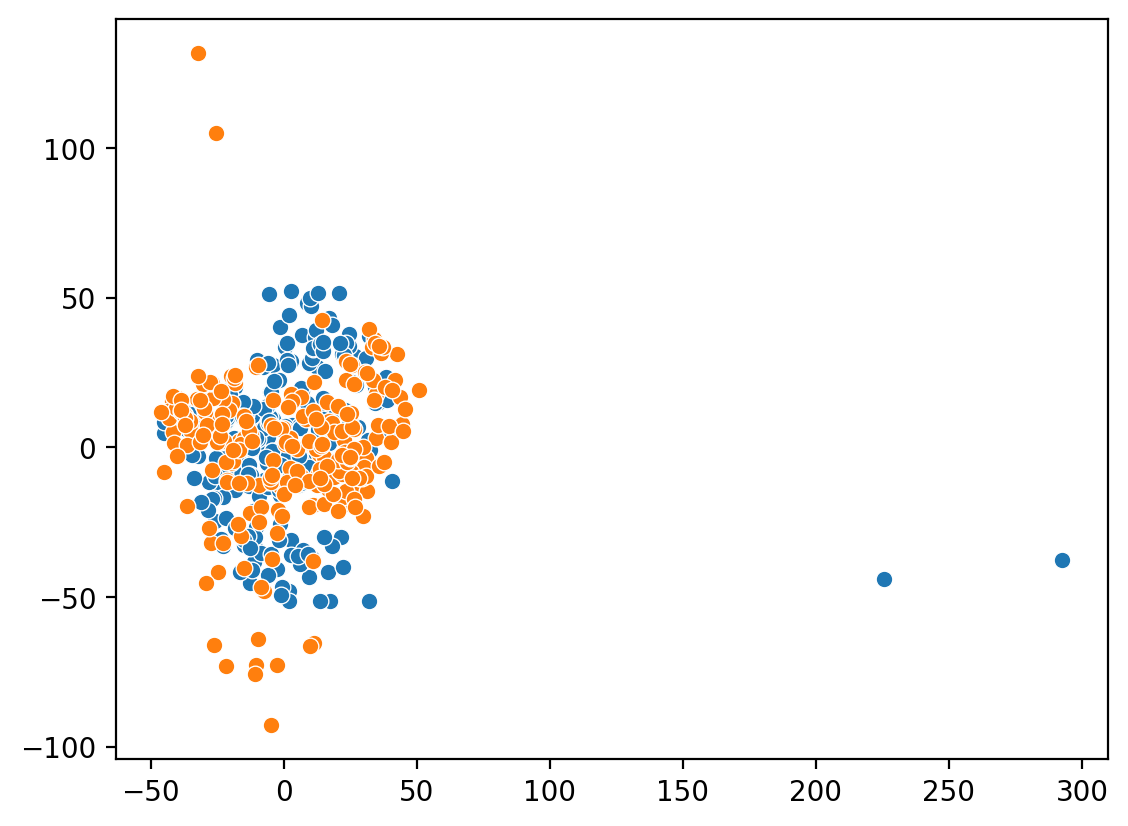

In [23]:
### PCA
embedding = Isomap(n_components=3)

original_reduced = embedding.fit_transform(original_embedded[10][0])
modified_reduced = embedding.fit_transform(modified_embedded[10][0])

sns.scatterplot(x = modified_reduced[:, 1], y = modified_reduced[:, 2])
sns.scatterplot(x = original_reduced[:, 1], y = original_reduced[:, 2])

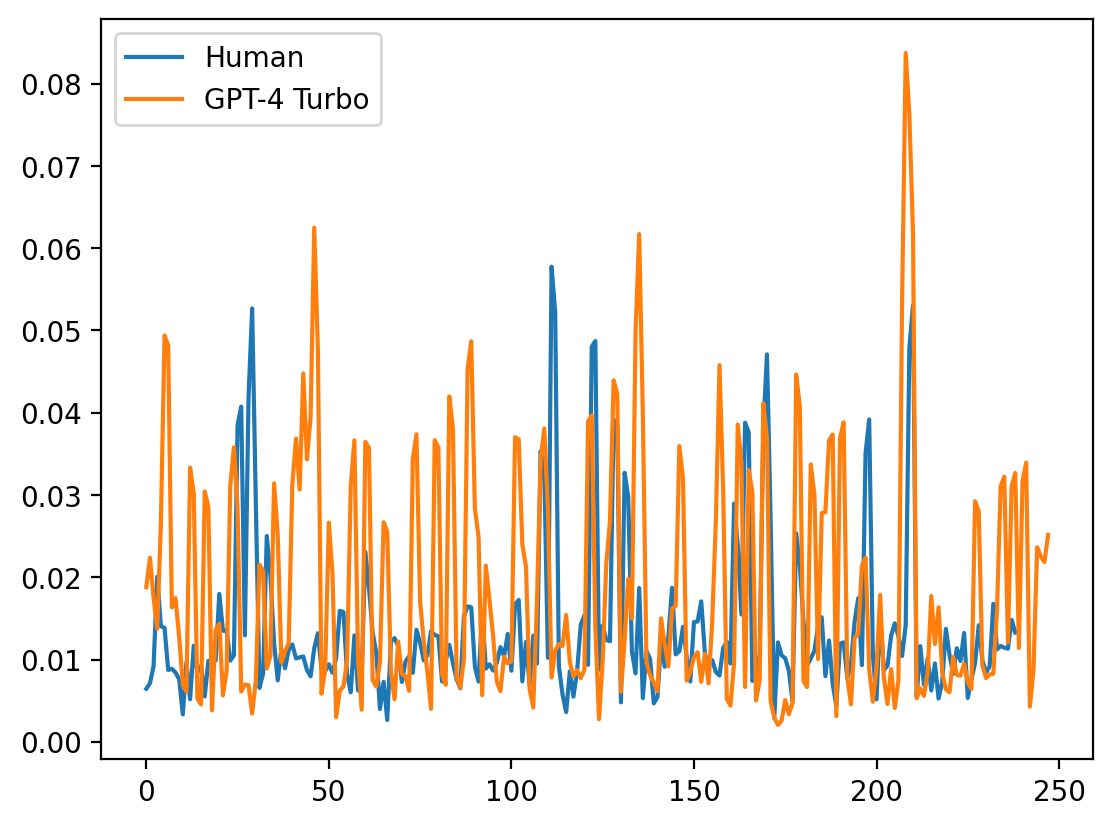

In [24]:
### Distance over token index
plt.plot(original_distances[0:len(modified_distances)], label = "Human")
plt.plot(modified_distances, label = "GPT-4 Turbo")
plt.legend()

In [176]:
results = []
for (ix, row) in tqdm(df.iterrows(), total=df.shape[0]):

    original = row['Original']
    modified = row['GPT_Response']
    
    original_embedded = embed_passage(original, model, tokenizer)
    modified_embedded = embed_passage(modified, model, tokenizer)


    for layer in range(len(original_embedded)):

        ### Get distances
        original_distances = get_distances(original_embedded, layer)
        modified_distances = get_distances(modified_embedded, layer)
    
        ### Get intrinsic dimensionality with pca
        original_id = calculate_id_pca(original_embedded, layer)
        modified_id = calculate_id_pca(modified_embedded, layer)
        
        results.append({
            'avg_distance': original_distances.mean(),
            'max_distance': original_distances.max(),
            'intrinsic_dim': original_id,
            'condition': 'original',
            # 'modified_avg_distance': modified_distances.mean(),
            'goal': 'original',
            'layer': layer,
            'item': ix
            
        })
    
        results.append({
            'avg_distance': modified_distances.mean(),
            'max_distance': modified_distances.max(),
            'intrinsic_dim': modified_id,
            'condition': 'modified',
            # 'modified_avg_distance': modified_distances.mean(),
            'goal': row['Goal'],
            'layer': layer,
            'item': ix
            
        })

  4%|█▌                                         | 7/200 [00:06<03:03,  1.05it/s]


KeyboardInterrupt: 

In [177]:
df_results = pd.DataFrame(results)
df_results.head(3)

,avg_distance,max_distance,intrinsic_dim,condition,goal,layer,item
0,0.914422,1.073483,85,original,original,0,0
1,0.939172,1.091520,78,modified,Easier,0,0
2,0.581793,0.881686,92,original,original,1,0


In [178]:
def get_category(row):
    if row['condition'] == "original":
        return "Original"
    return row["goal"]
df_results['category'] = df_results.apply(get_category, axis = 1)

/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='layer', ylabel='avg_distance'>

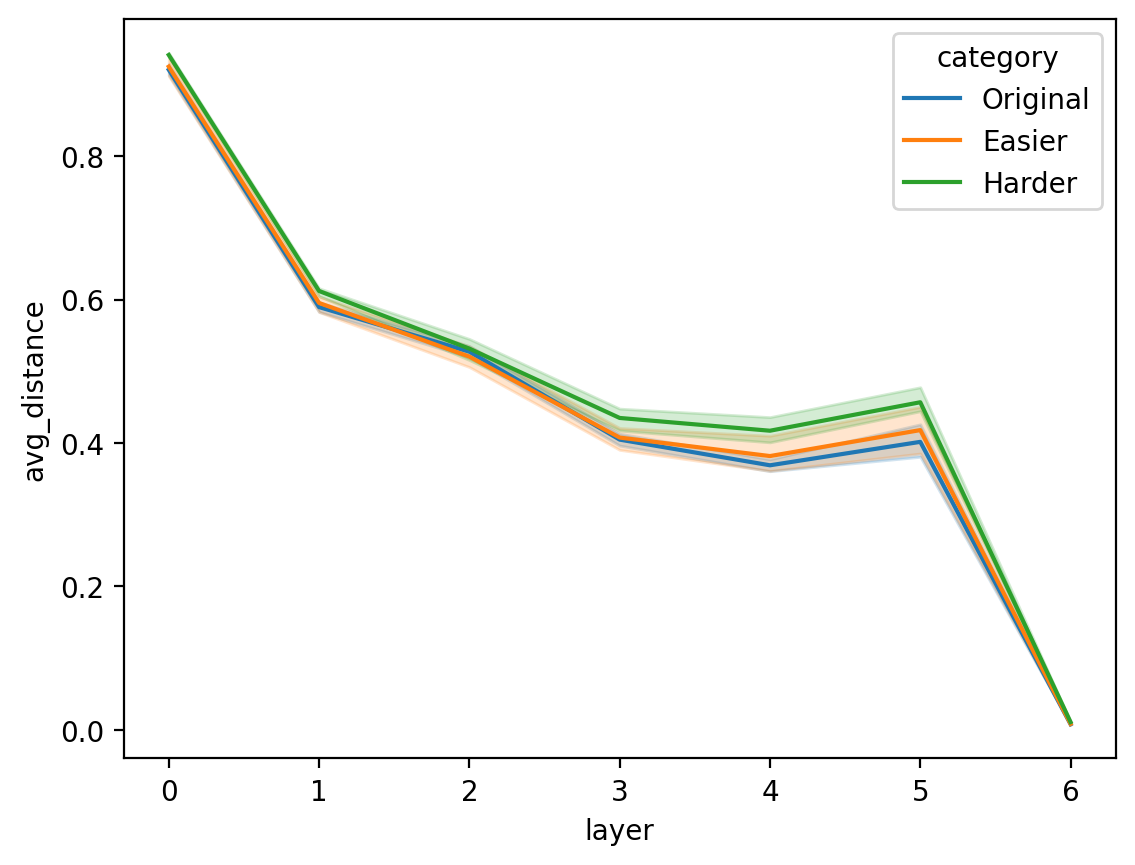

In [179]:
sns.lineplot(data = df_results, x = "layer", y = "avg_distance", 
            hue = "category")

/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='layer', ylabel='max_distance'>

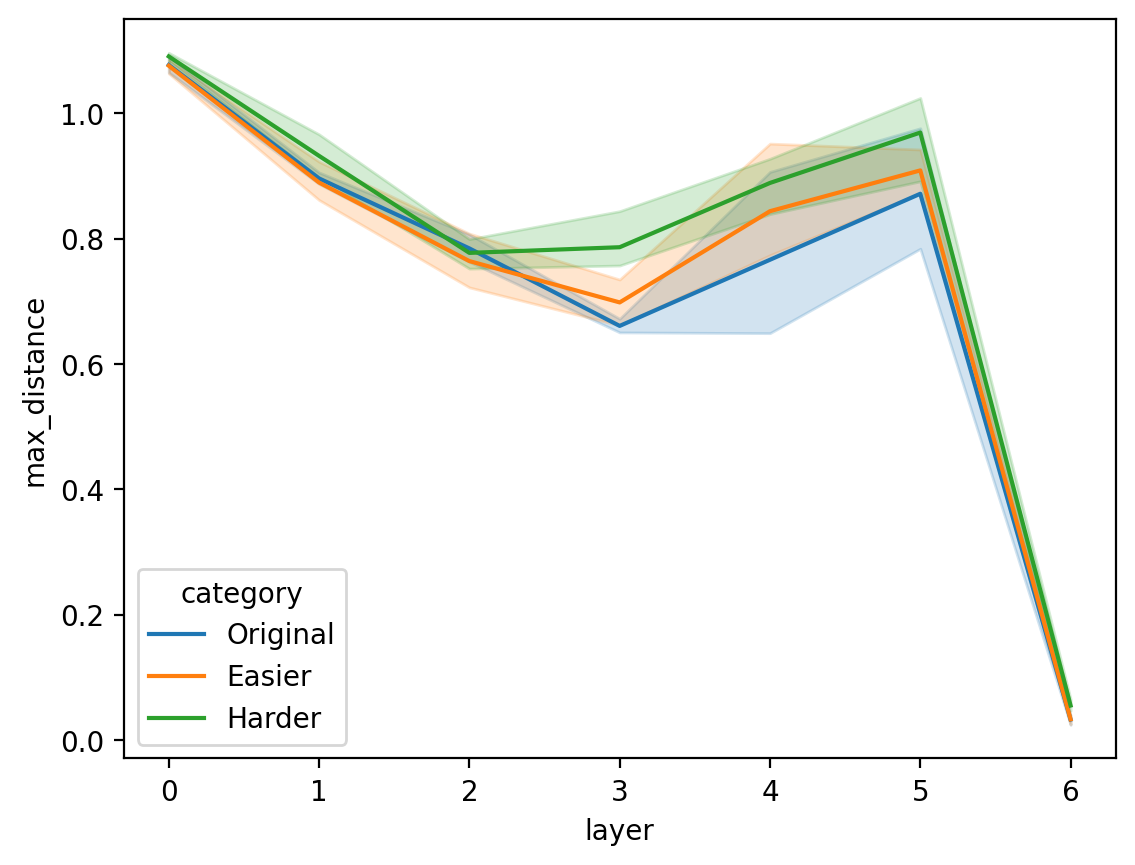

In [180]:
sns.lineplot(data = df_results, x = "layer", y = "max_distance", 
            hue = "category")

/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='layer', ylabel='intrinsic_dim'>

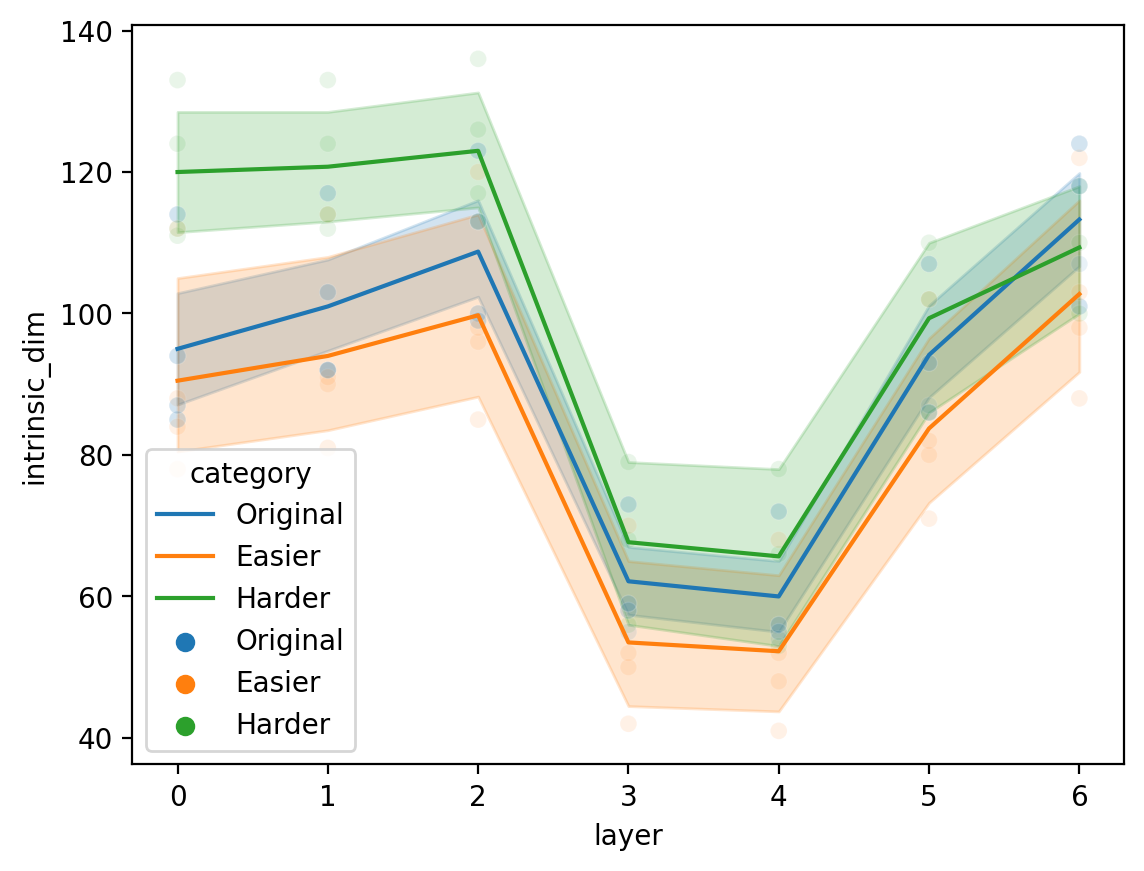

In [181]:
sns.lineplot(data = df_results, x = "layer", y = "intrinsic_dim", 
            hue = "category")

sns.scatterplot(data = df_results, x = "layer", y = "intrinsic_dim", 
            hue = "category", alpha = .1)


<Axes: xlabel='category', ylabel='max_distance'>

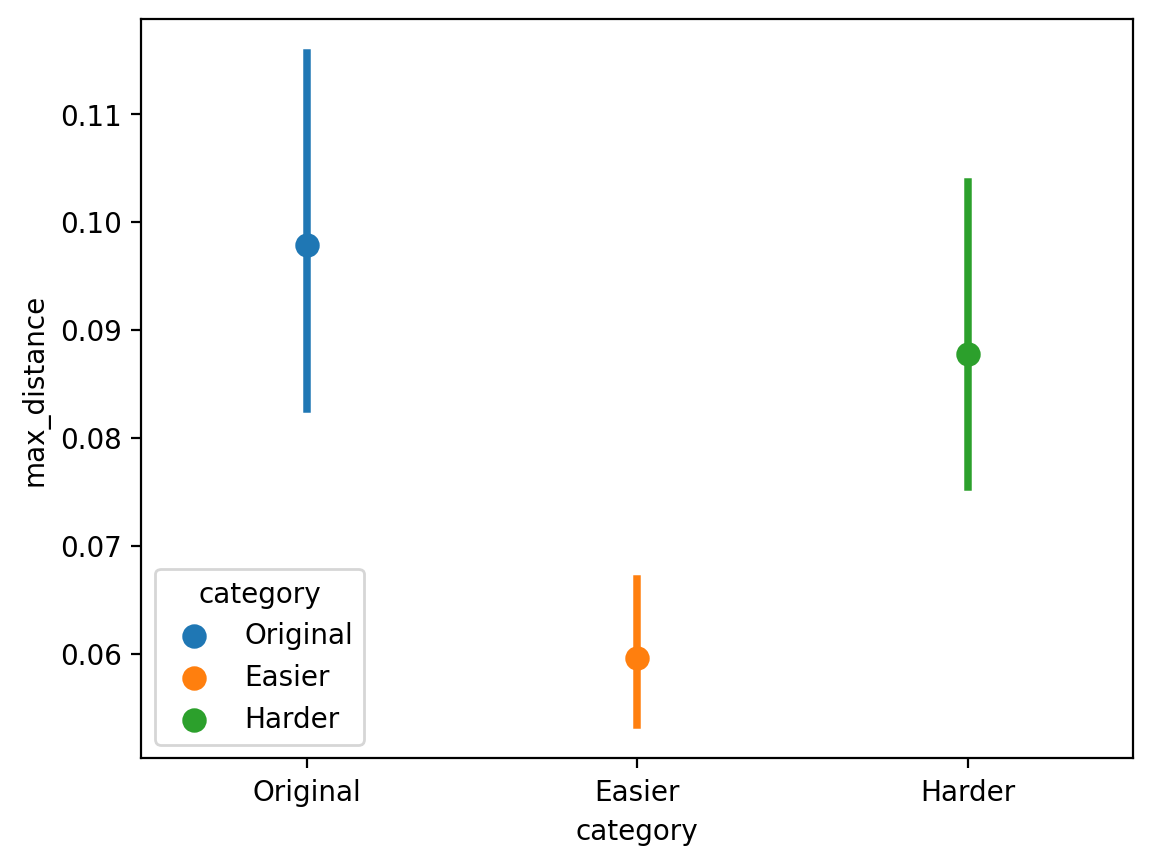

In [161]:
sns.pointplot(data = df_results[df_results['layer']==12], 
             x = "category", y = "max_distance", hue = "category")

<Axes: xlabel='category', ylabel='avg_distance'>

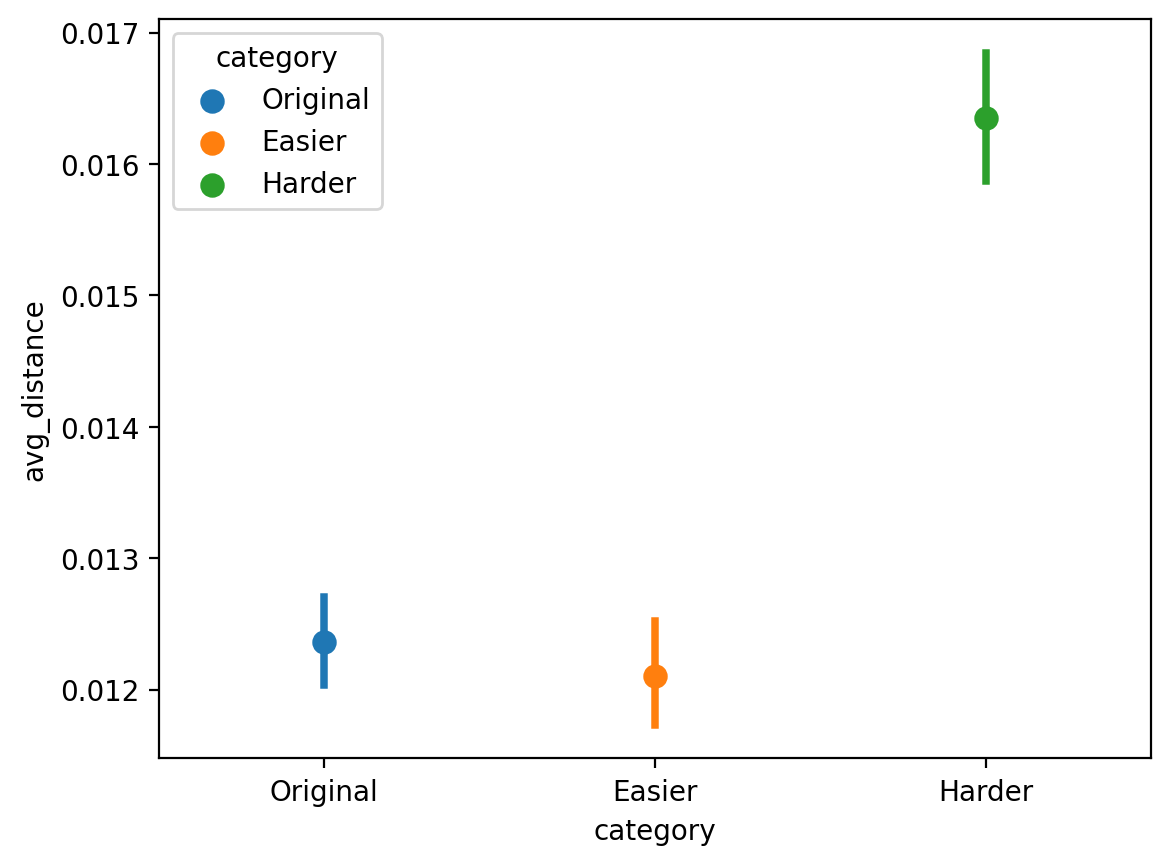

In [162]:
sns.pointplot(data = df_results[df_results['layer']==12], 
             x = "category", y = "avg_distance", 
            hue = "category")

<Axes: xlabel='category', ylabel='intrinsic_dim'>

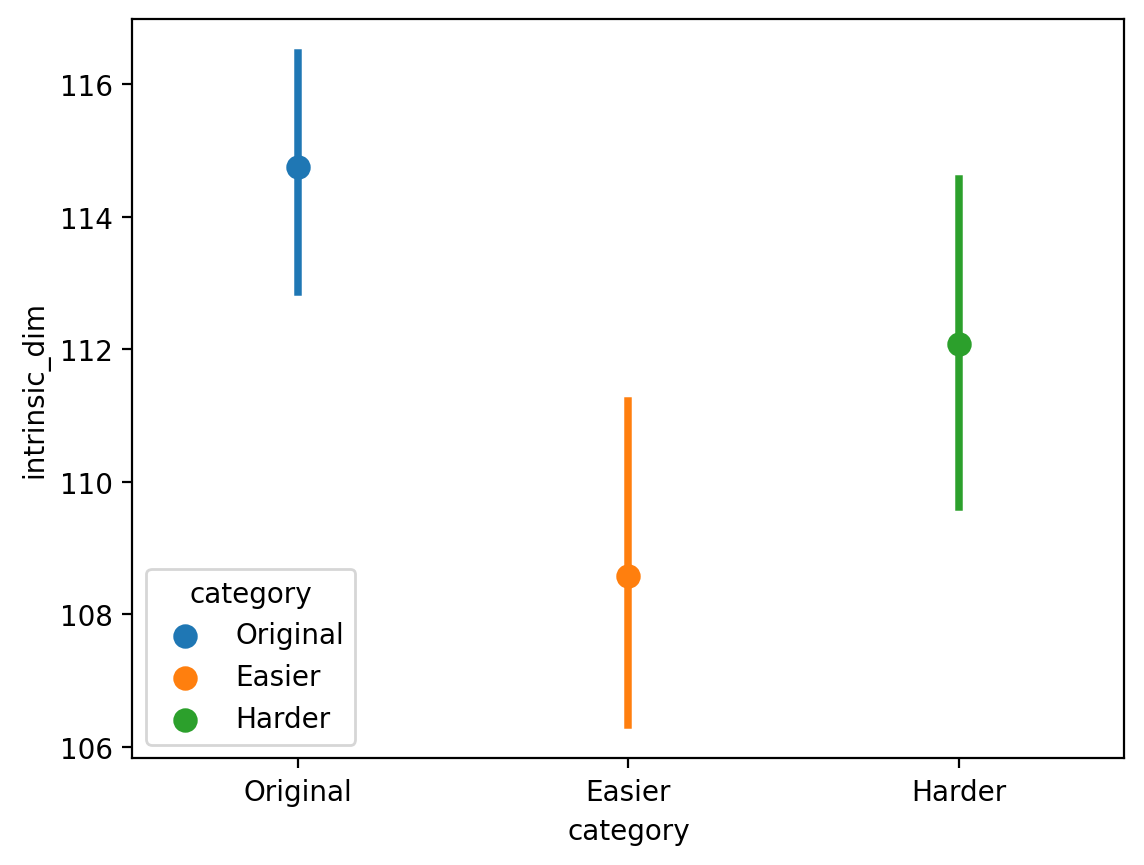

In [165]:
sns.pointplot(data = df_results[df_results['layer']==12], 
             x = "category", y = "intrinsic_dim", 
            hue = "category")

In [ ]:
?